In [1]:
!pip install rasterio
!pip install wandb

You should consider upgrading via the '/home/mcgrau/PycharmProjects/SS22_AIML/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/mcgrau/PycharmProjects/SS22_AIML/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
import torchvision.transforms as transforms

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import wandb
import pandas as pd
from PIL import Image

In [5]:
# create models sub-directory inside the Colab Notebooks directory
models_directory = '/home/mcgrau/PycharmProjects/SS22_AIML/models'
test_directory = '/home/mcgrau/PycharmProjects/SS22_AIML/data/testset'

In [6]:
classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
]

In [7]:
# change this to your eurosat path
eurosat_dir = "ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
samples = glob.glob(os.path.join(eurosat_dir, "*", "*.tif"))
len(samples)

27000

In [8]:
sample_idx = 111
sample = samples[sample_idx]
label = sample.split('/')[-1].split('_')[0]
print(label)

PermanentCrop


In [9]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled[2, 2, 2, 2]
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [10]:
!nvidia-smi

Wed Apr 20 15:48:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P0    20W /  N/A |     13MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [12]:
class SatelliteDataset(Dataset):
    """Create own dataset."""

    def __init__(self, transform=False):
        self.eurosat_dir = "ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
        self.samples = glob.glob(os.path.join(self.eurosat_dir, "*", "*.tif"))
        self.transform = transform

    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input = self.samples[idx]
        label = input.split('/')[-1].split('_')[0]
        label = class_to_idx[label]
        with rio.open(input, "r") as d:
          image = d.read([1,2,3,4,5,6,7,8,9,11,12,13]).astype(int)
          image = reshape_as_image(image)

        if self.transform:
            image = transforms.ToTensor()(image)

        return image, label

In [13]:
trainData = SatelliteDataset(transform = True)

In [14]:
from functools import partial
from typing import Type, Any, Callable, Union, List, Optional

import torch
import torch.nn as nn
from torch import Tensor



__all__ = [
    "ResNet",
    "ResNet18_Weights",
    "resnet18"
]


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 10,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        #_log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(12, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.logsoftmax = nn.LogSoftmax(dim=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.logsoftmax(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)



In [15]:
model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2])
model = model.to(device)

In [16]:
!nvidia-smi

Wed Apr 20 15:48:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P0    21W /  N/A |   1038MiB /  7982MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
nll_loss = nn.NLLLoss()
nll_loss = nll_loss.to(device)

In [18]:
learning_rate = 0.001
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)

In [19]:
num_epochs = 150
mini_batch_size = 2000
train_loader = DataLoader(trainData, batch_size=mini_batch_size, shuffle=True, num_workers=0)

In [20]:
torch.autograd.set_detect_anomaly(False)

# start monitoring
wandb.init()

# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the CIFAR10 model
for epoch in range(num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_loader):

        # push mini-batch data to computation device
        images = images.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.float)

        # run forward pass through the network
        output = model(images)

        # reset graph gradients
        model.zero_grad()

        labels=labels.to(torch.int64)

        # determine classification loss
        loss = nll_loss(output, labels)

        # run backward pass
        loss.backward()

        # update network paramaters
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))

    # set filename of actual model
    model_name = 'resnet_model_epoch_{}.pth'.format(str(epoch))

    # save current model to GDrive models directory
    if (epoch % 10) == 0 or epoch == (num_epochs - 1):
      torch.save(model.state_dict(), os.path.join(models_directory, model_name))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

wandb: Currently logged in as: unisg-ds-nlp (use `wandb login --relogin` to force relogin)


[LOG 20220420-13:49:32] epoch: 0 train-loss: 1.0853094926902227
[LOG 20220420-13:50:48] epoch: 1 train-loss: 0.40037586859294344
[LOG 20220420-13:52:04] epoch: 2 train-loss: 0.3075839174645288
[LOG 20220420-13:53:20] epoch: 3 train-loss: 0.22605963796377182
[LOG 20220420-13:54:37] epoch: 4 train-loss: 0.17984807171991893
[LOG 20220420-13:55:53] epoch: 5 train-loss: 0.1486909565116678
[LOG 20220420-13:57:10] epoch: 6 train-loss: 0.116673046456916
[LOG 20220420-13:58:27] epoch: 7 train-loss: 0.08580646397812026
[LOG 20220420-13:59:44] epoch: 8 train-loss: 0.06971496263785022
[LOG 20220420-14:01:00] epoch: 9 train-loss: 0.05641913839748928
[LOG 20220420-14:02:17] epoch: 10 train-loss: 0.03769051789173058
[LOG 20220420-14:03:34] epoch: 11 train-loss: 0.062223504430481365
[LOG 20220420-14:04:51] epoch: 12 train-loss: 0.04259090404957533
[LOG 20220420-14:06:07] epoch: 13 train-loss: 0.026722495776734183
[LOG 20220420-14:07:25] epoch: 14 train-loss: 0.025471508902098452
[LOG 20220420-14:08:43

wandb: Network error (ReadTimeout), entering retry loop.


[LOG 20220420-15:59:35] epoch: 99 train-loss: 1.0090739189243842e-05
[LOG 20220420-16:01:00] epoch: 100 train-loss: 1.0034478464149288e-05
[LOG 20220420-16:02:31] epoch: 101 train-loss: 9.723553960481826e-06
[LOG 20220420-16:03:55] epoch: 102 train-loss: 9.786796194280864e-06
[LOG 20220420-16:05:19] epoch: 103 train-loss: 9.171182065464173e-06
[LOG 20220420-16:06:42] epoch: 104 train-loss: 8.590088132872811e-06
[LOG 20220420-16:08:04] epoch: 105 train-loss: 8.358013993919095e-06
[LOG 20220420-16:09:24] epoch: 106 train-loss: 8.955769447181541e-06
[LOG 20220420-16:10:44] epoch: 107 train-loss: 8.616789987822163e-06
[LOG 20220420-16:12:08] epoch: 108 train-loss: 7.88358342366077e-06
[LOG 20220420-16:13:41] epoch: 109 train-loss: 8.589743401898886e-06
[LOG 20220420-16:15:03] epoch: 110 train-loss: 8.166602648478666e-06
[LOG 20220420-16:16:24] epoch: 111 train-loss: 8.174544843443852e-06
[LOG 20220420-16:17:44] epoch: 112 train-loss: 7.722715638789981e-06
[LOG 20220420-16:19:05] epoch: 113

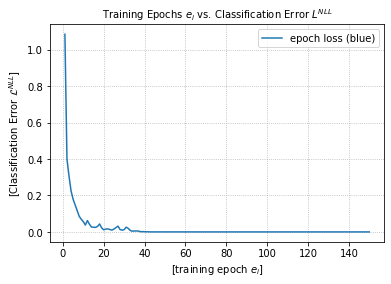

In [21]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

In [22]:
print(test_directory)

/home/mcgrau/PycharmProjects/SS22_AIML/data/testset


In [23]:
testSamples = glob.glob(os.path.join(test_directory, "*.npy"))
len(testSamples)

4232

In [24]:
class testDataset(Dataset):
    def __init__(self, test_directory, transform=False):
        self.files = glob.glob(os.path.join(test_directory, "*.npy"))
        self.transform = transform

    def __len__(self):
      return len(self.files)

    def __getitem__(self, idx):
        item = self.files[idx]
        image = np.load(item).astype(int)
        number = int(item.split('/')[-1].split('_')[1].split('.')[0])

        if self.transform:
          image = transforms.ToTensor()(image).to(torch.float)

        return image, number

In [25]:
testData = testDataset(test_directory = test_directory, transform = True)

In [26]:
test_loader = DataLoader(testData, shuffle=False)

In [27]:
# restore pre-trained model snapshot
best_model_name = os.path.join(models_directory, 'cifar10_model_epoch_200.pth')

# load state_dict from path
state_dict_best = torch.load(best_model_name, map_location=torch.device('cpu'))

# init pre-trained model class
best_model = RESNET18()

# load pre-trained models
best_model.load_state_dict(state_dict_best)

NameError: name 'RESNET18' is not defined

In [ ]:
# set model in evaluation mode
best_model.eval()

In [ ]:
predictions = []
numbers = []

for i, (images, nums) in enumerate(test_loader):
    # run forward pass through the network
    pred = torch.argmax(best_model(images), dim=1)
    predictions.append(pred.int().item())
    numbers.append(nums.int().item())

In [ ]:
print(len(predictions))

In [ ]:
print(numbers)

In [ ]:
predClasses = np.vectorize(idx_to_class.get)(predictions)

d = {'test_id': numbers, 'label': predClasses}
predData = pd.DataFrame(data = d)
predData = predData.sort_values(by=['test_id'])
print(predData.head(10))

In [ ]:
print(len(predData))

In [ ]:
predData.to_csv(os.path.join(models_directory,'submission.csv'), index = False)

In [ ]:
idx_to_class

In [ ]:
print(predictions[0])

In [ ]:
np.unique(preds)